<a href="https://colab.research.google.com/github/CAVASOL/aiffel_quest/blob/main/DL_quest/main_quest_04/mq4_holdup_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Main Quest 04. 폐렴아 기다려라 - 프로젝트


### 학습 내용

* 노드 5의 실습 과정을 되짚어보면서 어떤 점을 더 개선해볼 수 있을지 살펴보고, 모델의 성능을 향상시켜 봅시다.
* ResNet18 모듈과 ResNet50 모듈을 사용하여 모델을 구현 해보고, 결과를 살펴봅니다.

### 목차

**6. 폐렴아 기다려라 - 프로젝트**

    6-1. 프로젝트 : 폐렴 진단기 성능개선
        Step 1. 실험환경 Set-up
        Step 2. 데이터 준비하기
        Step 3. 데이터 시각화
        Step 4. ResNet-18 구현
        Step 5. 데이터 imbalance 처리
        Step 6. 모델 훈련
        Step 7. 결과 확인과 시각화

        ** ResNet50 구현
        ** 데이터 imbalance 처리
        ** 모델 훈련
        ** 결과 확인과 시각화
    
    6-2. 프로젝트 제출

### 6-1. 프로젝트 : 폐렴 진단기 성능개선

**Step 1. 실험환경 Set-up**

In [ ]:
# Lib

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

print(tf.__version__)

2.6.0


실험에 필요한 변수들을 생성합니다.  
노드 5의 실험에서는 이미지 크기를 180x180으로 설정했으나, ResNet 모델이 기본적으로 224x224 크기의 이미지를 사용하므로 이미지 크기를 변경합니다.

In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈
IMAGE_SIZE = [224, 224]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래에서 두 변수를 변경할 예정입니다.
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


**Step 2. 데이터 준비하기**

`원본 데이터를 가져와서 전처리 및 배치 구성`을 진행합니다. 의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다. 이전 실습에서 고려하지 않았던 `augmentation 기법`을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다. 그래서 augmentation 도입은 신중해야 합니다.

In [ ]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print("Train data:", len(train_filenames))
print("Test data:", len(test_filenames))
print("Validation data:", len(val_filenames))

Train data: 5216
Test data: 624
Validation data: 16


train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다. 개수 비는 89%, 10.7%, 0.3% 입니다.  
train에서 val에 쓰일 데이터를 더 가져와서 train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

In [ ]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print("Train data:", len(train_filenames))
print("Validation data:", len(val_filenames))

Train data: 4185
Validation data: 1047


이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 확인해 보겠습니다.

In [ ]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0479-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1087
Pneumonia images count in training set: 3098


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용한 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다. tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.

In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


좋습니다. 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있으므로, 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [ ]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다. `decode_img` 함수와 `process_path` 함수를 만들겠습니다. `process_path` 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다.

In [ ]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

`train 데이터 셋`과 `validation 데이터 셋`을 만듭니다.  
num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지 크기가 잘 조정 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  False


폐렴이면 양성(True), 노말이면 음성(False)을 의미합니다. 사이즈가 잘 변환되어 있고 라벨도 잘 들어가 있네요.  
 위에서 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다. 그리고 데이터 개수도 확인해보겠습니다.

In [ ]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print("Test image count:", TEST_IMAGE_COUNT)

Test image count: 624


위에서 언급한 것처럼 의료영상 이미지의 특성상 데이터가 충분하지 않지만, 이를 극복할 수 있는 방법으로 augmentation 기법을 적용해 볼 수 있습니다.

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.  
tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

* shuffle() 고정 크기 버퍼 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소 선택.
* repeat() 데이터셋을 여러 번 사용.
* batch() BATCH_SIZE 배치 조정.
* refetch() 리소스의 유휴 상태 셋업.

**Step 3. 데이터 시각화**

학습용 데이터를 시각화해서 확인해 봅니다. 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다.  
추출된 배치를 image와 label 데이터 셋으로 나누고, show_batch() 함수를 통해 이미지의 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

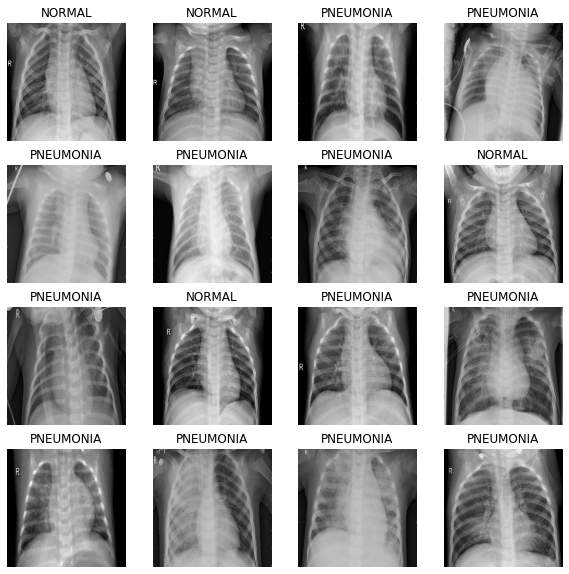

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

**Step 4. ResNet-18 구현**

의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해 볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다. 이번 스텝에서는 `ResNet-18 구현`을 진행합니다. ResNet은 2015년 ILSVRC 대회 (ImageNet Large Scale Visual Recognition Challenge)에서 엄청난 성능을 보여주었던 모델입니다. ResNet의 특징이라면 `Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지했다`는 점입니다. ResNet의 Residual Connection은 이후에 나오는 Transformer와 같은 모델에도 사용되고 있습니다. 우리는 ResNet의 가장 작은 버전인 ResNet-18로 구현하려고 합니다.

ResNet-18와 같은 ResNet의 기본 버전을 구현하려면 Residual Block을 만들어야 합니다.  
Residual Block은 ResNet 아키텍처에서 매우 중요한 구성 요소 중 하나이며, 여러 레이어로 구성됩니다.  
Residual Block의 각 레이어에 대한 설명은 다음과 같습니다:

1. 3x3 CNN (합성곱 레이어):
    * 이 레이어는 3x3 크기의 커널(필터)을 사용하여 입력 데이터에서 특징을 추출하는 합성곱 레이어입니다.
    * 이 합성곱 레이어는 일반적으로 ReLU 활성화 함수를 포함하고, 필터 수를 조절하여 특징 맵의 차원을 변경합니다.  
        ResNet-18의 경우, 이 레이어는 64개의 필터를 사용할 수 있습니다.  
        

2. BatchNormalization (배치 정규화):
    * BatchNormalization은 미니배치의 각 데이터에 대해 정규화를 수행하는 레이어입니다. (네트워크의 안정성 향상, 학습 속도 가속화)  
    * BatchNormalization은 각 미니배치의 평균 및 표준 편차를 계산하고, 이를 사용하여 입력 데이터를 정규화합니다.
    * 정규화된 데이터는 스케일링 및 이동 파라미터에 따라 조절됩니다.  
    

3. Residual Connection (잔여 연결):
    * Residual Block의 핵심 요소로, 입력 데이터와 레이어 출력 사이에 추가된 스킵 연결을 의미합니다.
    * 잔여 연결은 레이어의 입력 데이터를 직접 레이어의 출력에 더함으로써, 레이어가 학습해야 하는 잔여 정보를 전달합니다.
    * 잔여 연결은 그라디언트 소실 문제를 해결하고, 더 깊은 네트워크를 학습하는데 도움을 줍니다.
    * ResNet의 핵심 아이디어 중 하나로, 매우 깊은 네트워크에서도 효과적인 학습을 가능하게 합니다.

In [ ]:
from tensorflow.keras import layers

def residual_block(x, filters, s=1):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), strides=s, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    if s != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=s, padding='valid')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

In [ ]:
def build_resnet18(input_shape=(224, 224, 3)):
    input_tensor = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, s=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, s=2)
    x = residual_block(x, 256)
    x = residual_block(x, 512, s=2)
    x = residual_block(x, 512)

    x = layers.Dropout(0.5)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x)

    return model

**Step 5. 데이터 imbalance 처리**

노드 5의 실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다.  
만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.68


**Step 6. 모델 훈련**



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

with tf.device('/GPU:0'):
    model = build_resnet18()


    METRICS = [
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]

    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=METRICS)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
BATCH_SIZE = 32 # 16에서 32로 조정
EPOCHS = 20 # 10에서 20으로 조정

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
130/130 [==============================] - 45s 245ms/step - loss: 0.4732 - accuracy: 0.8447 - precision: 0.9411 - recall: 0.8467 - val_loss: 17.8469 - val_accuracy: 0.7598 - val_precision: 0.7598 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 31s 240ms/step - loss: 0.2436 - accuracy: 0.9120 - precision: 0.9670 - recall: 0.9102 - val_loss: 3.1697 - val_accuracy: 0.7637 - val_precision: 0.7637 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 31s 243ms/step - loss: 0.2237 - accuracy: 0.9168 - precision: 0.9716 - recall: 0.9141 - val_loss: 0.2256 - val_accuracy: 0.9062 - val_precision: 0.9453 - val_recall: 0.9308
Epoch 4/20
130/130 [==============================] - 32s 248ms/step - loss: 0.1884 - accuracy: 0.9255 - precision: 0.9714 - recall: 0.9267 - val_loss: 23.5317 - val_accuracy: 0.2344 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
130/130 [==============================] - 34s 264ms/step - loss: 0.187

**Step 7. 결과 확인과 시각화**

그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

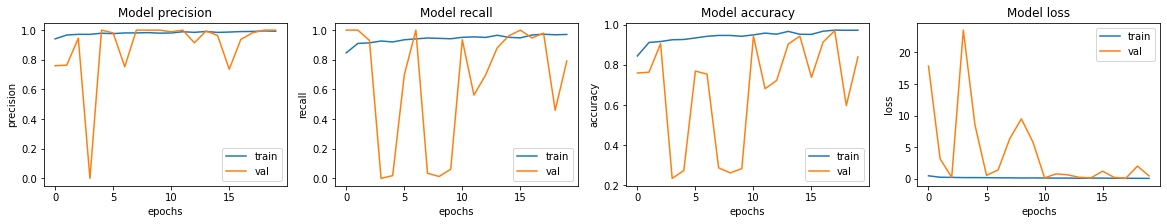

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

`테스트 데이터로 모델 평가`를 해보겠습니다. 모델 평가를 위해 `loss`, `accuracy`, `precision`, `recall` 값을 출력해보겠습니다.

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 120ms/step - loss: 0.3427 - accuracy: 0.8766 - precision: 0.9311 - recall: 0.8667
Loss: 0.3426632583141327,
Accuracy: 0.8766025900840759,
Precision: 0.9311294555664062,
Recall: 0.8666666746139526


**ResNet50 구현**

In [ ]:
# ResNet50

from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

def build_resnet50():
    base_model = ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=base_model.input, outputs=output)

    return model

In [ ]:
# 데이터 imbalance 처리

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.68


In [ ]:
# Compile

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

with tf.device('/GPU:0'):
    model = build_resnet50()

    METRICS = [
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]

    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=METRICS)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Fitting

BATCH_SIZE = 32 # 16에서 32로 조정
EPOCHS = 20 # 10에서 20으로 조정

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
130/130 [==============================] - 52s 289ms/step - loss: 0.5089 - accuracy: 0.8298 - precision: 0.9398 - recall: 0.8249 - val_loss: 2.7402 - val_accuracy: 0.7715 - val_precision: 0.7715 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 36s 277ms/step - loss: 0.2178 - accuracy: 0.9111 - precision: 0.9694 - recall: 0.9081 - val_loss: 3.5210 - val_accuracy: 0.7441 - val_precision: 0.7441 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 36s 278ms/step - loss: 0.2638 - accuracy: 0.9029 - precision: 0.9661 - recall: 0.8989 - val_loss: 3.0633 - val_accuracy: 0.7539 - val_precision: 0.7539 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 35s 273ms/step - loss: 0.1995 - accuracy: 0.9231 - precision: 0.9728 - recall: 0.9226 - val_loss: 1.5296 - val_accuracy: 0.5449 - val_precision: 0.9936 - val_recall: 0.4005
Epoch 5/20
130/130 [==============================] - 35s 273ms/step - loss: 0.1626 - accura

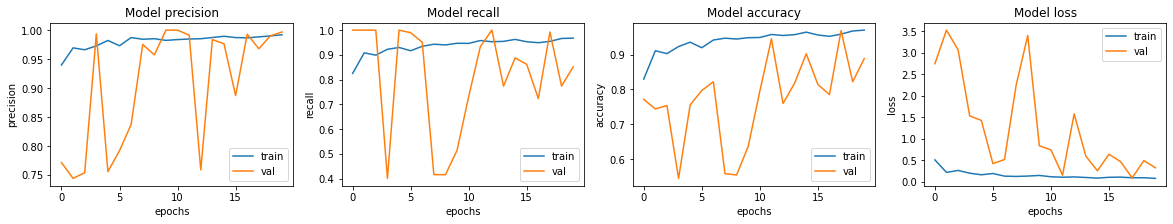

In [ ]:
# Visualization

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# Evaluation

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 125ms/step - loss: 0.5212 - accuracy: 0.8285 - precision: 0.8180 - recall: 0.9333
Loss: 0.5211844444274902,
Accuracy: 0.8285256624221802,
Precision: 0.8179775476455688,
Recall: 0.9333333373069763
